In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, time
from collections import defaultdict
import requests

In [56]:
aqi = {}
with open("Intermediate Data/santa_fe_yearly_aqi.json", 'r') as json_file:
    aqi = json.load(json_file)
aqi = pd.DataFrame(list(aqi.items()), columns=['year', 'aqi']).astype({'year': 'int64'})

In [4]:
fires = []
with open("Intermediate Data/santa_fe_fires.json", 'r') as json_file:
    fires = json.load(json_file)

In [42]:
emergency_department_visits = pd.read_csv("Starting Data/asthma_data/asthma_ed_counts.csv").drop("county", axis = 1)
hospital_admissions = pd.read_csv("Starting Data/asthma_data/asthma_hospital_admissions.csv").drop("county", axis = 1)

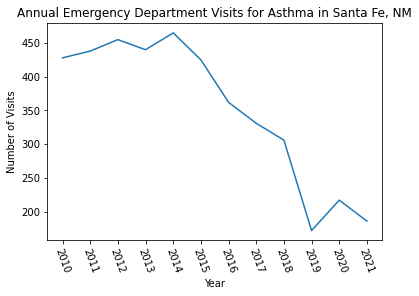

In [6]:
plt.plot(emergency_department_visits["year"], emergency_department_visits["primary_asthma_ed_visit_counts"])
plt.title("Annual Emergency Department Visits for Asthma in Santa Fe, NM")
plt.xticks(emergency_department_visits["year"], rotation=290)
plt.xlabel("Year")
plt.ylabel("Number of Visits")
plt.show()

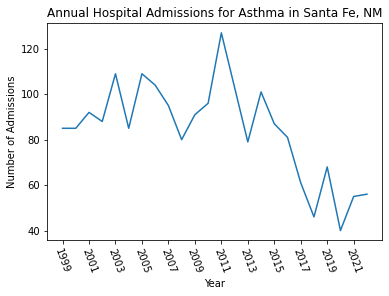

In [7]:
plt.plot(hospital_admissions["year"], hospital_admissions["primary_asthma_hospital_admissions"])
plt.title("Annual Hospital Admissions for Asthma in Santa Fe, NM")
plt.xticks(range(hospital_admissions["year"][0], hospital_admissions["year"].iloc[-1], 2), rotation=290)
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.show()

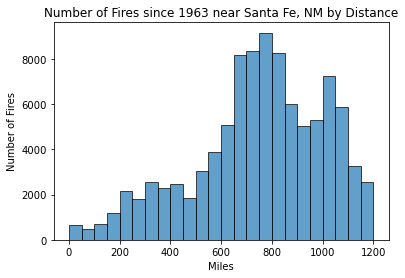

In [10]:
distances = [feature['attributes']['Distance_to_SF'] for feature in fires]
year_buckets = range(0, 1250, 50)
plt.hist(distances, bins = year_buckets, edgecolor='black', alpha=0.7)
plt.xlabel('Miles')
plt.ylabel('Number of Fires')
plt.title('Number of Fires since 1963 near Santa Fe, NM by Distance')
plt.show()

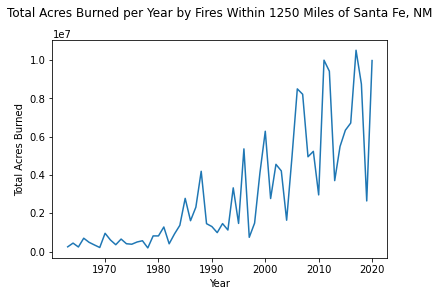

In [8]:
from collections import defaultdict
acreage_by_year = defaultdict(float)
for feature in fires:
    acreage_by_year[feature['attributes']['Fire_Year']] += feature['attributes']['GIS_Acres']
    
plt.plot(list(acreage_by_year.keys()), list(acreage_by_year.values()))
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year by Fires Within 1250 Miles of Santa Fe, NM', y=1.08)
plt.show()

In [16]:
import folium
santa_fe_coords = [35.6869, -105.9378]

# Create a map initially centered around Santa Fe
m = folium.Map(location=santa_fe_coords, zoom_start=7)

# Add a circle with a radius of 200 miles around Santa Fe
for radius, col in zip([200, 400, 600, 800, 1000, 1200], ['green', 'green', 'green', 'red', 'red', 'red']):
    folium.Circle(location=santa_fe_coords, radius=radius * 1609.34, color=col, fill=False).add_to(m)

# Save the map to an HTML file for viewing
m.save('santa_fe_circle_map.html')

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

In [61]:
df = pd.read_csv("Intermediate Data/annual_smoke_estimate.csv")
df = df.merge(emergency_department_visits, 'left', 'year').merge(hospital_admissions, 'left', 'year').merge(aqi, 'left', 'year')

-0.08181818181818183
0.8109903943000458


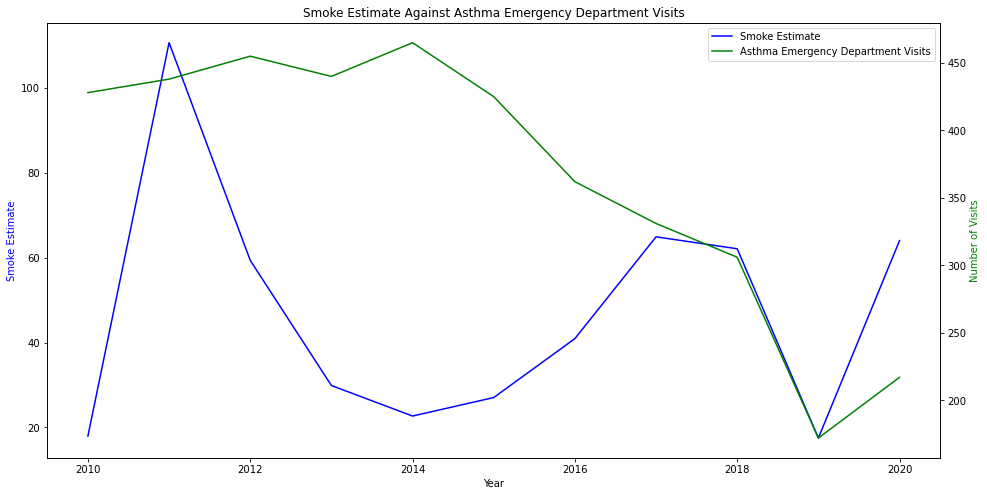

In [131]:
import scipy.stats
subset = df[["year", "smoke_estimate", "primary_asthma_ed_visit_counts"]].dropna(axis = 0)
correlation_coefficient, p_value = scipy.stats.spearmanr(subset.iloc[:, 1], subset.iloc[:, 2])
print(correlation_coefficient)
print(p_value)
fig, ax1 = plt.subplots(figsize = (16, 8))
ax1.plot(subset['year'], subset['smoke_estimate'], color='blue', label='Smoke Estimate')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
# ax1.tick_params('y', colors='blue')
ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['primary_asthma_ed_visit_counts'], color='green', label='Asthma Emergency Department Visits')
ax2.set_ylabel('Number of Visits', color='green')
# ax2.tick_params('y', colors='green')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.title("Smoke Estimate Against Asthma Emergency Department Visits")
plt.show()

-0.011874481754382792
0.9581727212680546


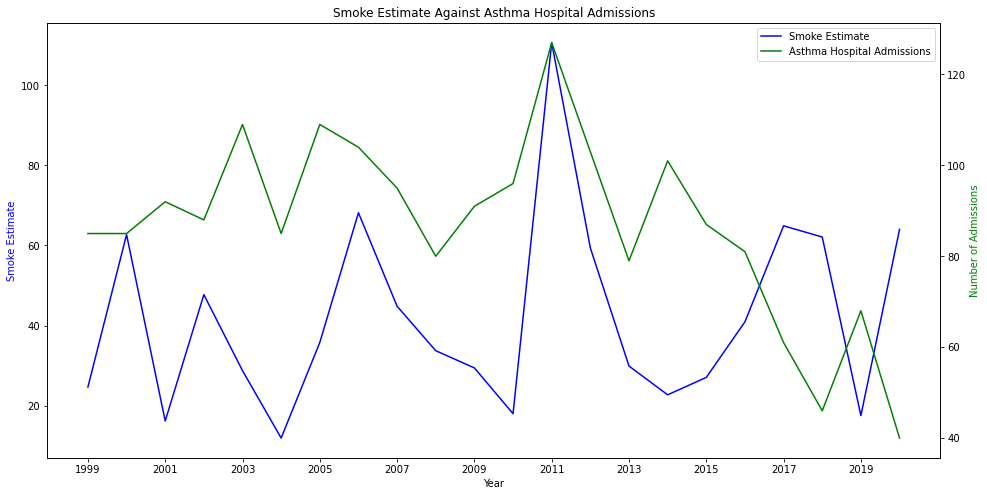

In [130]:
import scipy.stats
subset = df[["year", "smoke_estimate", "primary_asthma_hospital_admissions"]].dropna(axis = 0)
correlation_coefficient, p_value = scipy.stats.spearmanr(subset.iloc[:, 1], subset.iloc[:, 2])
print(correlation_coefficient)
print(p_value)
fig, ax1 = plt.subplots(figsize = (16, 8))
ax1.plot(subset['year'], subset['smoke_estimate'], color='blue', label='Smoke Estimate')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
# ax1.tick_params('y', colors='blue')
ax2 = ax1.twinx()
ax2.plot(subset['year'], subset['primary_asthma_hospital_admissions'], color='green', label='Asthma Hospital Admissions')
ax2.set_ylabel('Number of Admissions', color='green')
# ax2.tick_params('y', colors='green')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.xticks(range(subset["year"].iloc[0], subset["year"].iloc[-1], 2))
plt.title("Smoke Estimate Against Asthma Hospital Admissions")
plt.show()

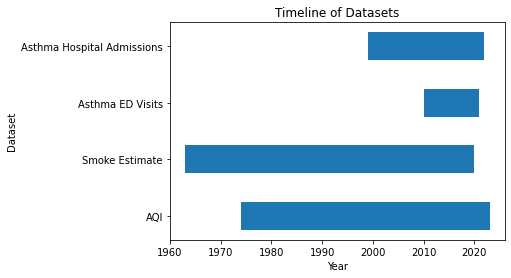

In [129]:
fig, ax = plt.subplots()

# Plot bars for each dataset
ax.broken_barh([(aqi["year"].iloc[0], aqi["year"].iloc[-1] - aqi["year"].iloc[0])], (0, 0.5))
smoke_estimate_years = list(smoke_estimate_by_year.keys())
ax.broken_barh([(smoke_estimate_years[0], smoke_estimate_years[-1] - smoke_estimate_years[0])], (1, 0.5))
ax.broken_barh([(emergency_department_visits["year"].iloc[0], emergency_department_visits["year"].iloc[-1] - emergency_department_visits["year"].iloc[0])], (2, 0.5))
ax.broken_barh([(hospital_admissions["year"].iloc[0], hospital_admissions["year"].iloc[-1] - hospital_admissions["year"].iloc[0])], (3, 0.5))


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Dataset')
ax.set_title('Timeline of Datasets')
ax.set_yticks([0.25, 1.25, 2.25, 3.25])
ax.set_yticklabels(["AQI", "Smoke Estimate", "Asthma ED Visits", "Asthma Hospital Admissions"])

plt.yticks()
plt.show()

In [66]:
subset = df.dropna(axis=0)
X = subset.drop("aqi", axis = 1)
y = subset["aqi"]
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X, y)
y_pred = xg_reg.predict(X)
plt.plot(X["year"], y)
plt.plot(X["year"], y_pred)
plt.show()